In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE  # Import SMOTE

def add_noise(data, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, data.shape)
    return data + noise

def create_sequences(data, sequence_length=100):
    X, y = [], []
    for i in range(len(data) - sequence_length + 1):
        sequence_data = data.iloc[i:i + sequence_length]
        X.append(sequence_data['Data'].values.reshape(-1, 1))
        # Count the number of ones in the 'Label' column of the current sequence
        label_count = sequence_data['Label'].sum()
        if label_count > 3:
            y.append(1)
        else:
            y.append(0)
    return np.array(X), np.array(y)

data = pd.read_csv('/content/labelled.csv')
data['Data'] = add_noise(data['Data'], noise_factor=0.01)

X, y = create_sequences(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train = X_train.reshape(X_train.shape[0], 100, 1)  # Reshape back to the original shape

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

model_lstm = Sequential([
    InputLayer(input_shape=(100, 1)),
    LSTM(50, return_sequences=True, unroll=True),
    LSTM(25, return_sequences=False, unroll=True),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping_lstm])
evaluation_lstm = model_lstm.evaluate(X_test, y_test)

print(f"LSTM-only Model Test Loss: {evaluation_lstm[0]}, Test Accuracy: {evaluation_lstm[1]}")
model_lstm.save('lstm_only_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 181s 49ms/step - accuracy: 0.8554 - loss: 0.3791 - val_accuracy: 0.9141 - val_loss: 0.2338
Epoch 2/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - accuracy: 0.9554 - loss: 0.1150 - val_accuracy: 0.9613 - val_loss: 0.1085
Epoch 3/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.9633 - loss: 0.0929 - val_accuracy: 0.9292 - val_loss: 0.1832
Epoch 4/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.9678 - loss: 0.0801 - val_accuracy: 0.9411 - val_loss: 0.1604
Epoch 5/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9712 - loss: 0.0724 - val_accuracy: 0.9600 - val_loss: 0.1053
Epoch 6/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9723 - loss: 0.0695 - val_accuracy: 0.9784 - val_loss: 0.0660
Epoch 7/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9730 - loss: 0.0672 - val_accuracy: 0.9701 - val_loss: 0.0780
Epoch 8/30
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9734 

LSTM-only Model Test Loss: 0.05752319470047951, Test Accuracy: 0.9721118211746216


842/842 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step


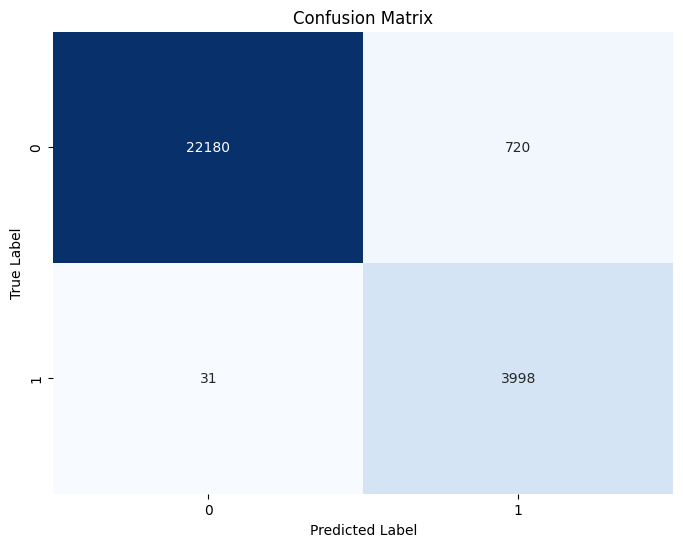

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     22900
           1       0.85      0.99      0.91      4029

    accuracy                           0.97     26929
   macro avg       0.92      0.98      0.95     26929
weighted avg       0.98      0.97      0.97     26929



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('lstm_only_model.h5')
y_pred_prob = model.predict(X_test)
is_binary_classification = y_pred_prob.shape[1] == 1
if is_binary_classification:
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
else:
    y_pred = np.argmax(y_pred_prob, axis=1)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test_labels, y_pred))
if is_binary_classification:
    fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
if 'history' in locals() or 'history' in globals():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [3]:
import tensorflow as tf

model = tf.keras.models.load_model("lstm_only_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp2_2i3nvn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132279094515264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279094525648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279094518256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279094595072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279094597888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279094598416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279094606512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279094604048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279093614848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279093617664: TensorSpec(shape=(), dtype=tf.resource, name=None)
